# Analyse RH : Préférence pour le Travail Flexible

#### Importer les librairies

In [1]:
# Importer les librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [2]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers

#### Affichage

In [3]:
# Option d'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

# format des graphiques
plt.rcParams['figure.figsize'] = (6, 4)

# Scaler pour normaliser les données
scaler = StandardScaler()

#### Importer les données

In [4]:
df = pd.read_excel("data/WorkFlexSurvey.xlsx")
df_null = pd.read_excel("data/WorkFlexSurvey-Null.xlsx")

In [5]:
print(df.shape)
print(df_null.shape)

(9000, 15)
(20, 15)


## Contexte et objectif

L’évolution des modes de travail et l’adoption accrue du télétravail ou des horaires flexibles posent des questions stratégiques aux entreprises. Les directions des ressources humaines souhaitent mieux comprendre quels facteurs influencent la volonté des employés d’opter pour un mode de travail flexible. Cette problématique est essentielle pour anticiper les préférences, élaborer des politiques internes adaptées et soutenir l’engagement des employés tout en assurant la performance organisationnelle.

Dans ce contexte, la capacité de prédire la préférence des employés pour un horaire flexible à partir de leurs caractéristiques personnelles et professionnelles devient un enjeu majeur d’aide à la décision RH.

L’objectif de cette première partie est de construire des modèles de classification supervisée capables de prédire si un employé est favorable à une politique de travail flexible. Ces modèles doivent s’appuyer sur les données disponibles pour identifier les variables explicatives les plus importantes et permettre une prédiction fiable. Plusieurs approches seront comparées, notamment les k plus proches voisins (KNN), les arbres de décision (CART, C5.0) et les réseaux de neurones.

## Analyse exploratoire

### 1.1. Analyse descriptive

Description du jeu de données « WorkFlexSurvey »

Le jeu de données « WorkFlexSurvey » contient 9 000 enregistrements représentant des employés issus de divers secteurs. Chaque enregistrement décrit le profil professionnel et personnel d’un employé ainsi que sa préférence pour un horaire flexible.

- Nombre total de variables : 15

    * 14 variables explicatives (entrées)

    * 1 variable cible (sortie)

#### 1.1.1. Statistiques descriptives globales

| **Variable**                   | **Description**                                                 | **Type**                    |
| ------------------------------ | --------------------------------------------------------------- | --------------------------- |
| **ID**                         | Identifiant unique de l’employé                                 | Numérique (Identifiant)     |
| **Prefers\_Flex\_Work**        | Préférence pour un horaire flexible (1 = oui, 0 = non)          | Binaire (Cible)             |
| **Age**                        | Âge de l’employé                                                | Numérique continu           |
| **Sector**                     | Secteur d’emploi                                                | Catégoriel nominal          |
| **Work\_Life\_Balance\_Score** | Score de l’équilibre vie pro/perso (1–10)                       | Numérique discret / Ordinal |
| **Commute\_Time**              | Temps de déplacement quotidien (minutes)                        | Numérique continu           |
| **Meetings\_per\_week**        | Nombre moyen de réunions par semaine                            | Numérique discret           |
| **Job\_Satisfaction**          | Niveau de satisfaction au travail (Low, Medium, High)           | Catégoriel ordinal          |
| **Manager\_Trust\_Score**      | Score de confiance envers la hiérarchie (1–10)                  | Numérique discret / Ordinal |
| **Has\_Dependent\_Children**   | Présence d’enfants à charge (1 = oui, 0 = non)                  | Binaire                     |
| **Tech\_Comfort\_Level**       | Niveau de confort avec les outils numériques (1–5)              | Numérique discret / Ordinal |
| **Health\_Status**             | Perception de la santé générale (Good, Average, Poor)           | Catégoriel ordinal          |
| **Annual\_Salary\_Bracket**    | Catégorie salariale ("<40k", "40k–70k", ">70k")                 | Catégoriel ordinal          |
| **Seniority\_Years**           | Ancienneté en années                                            | Numérique continu           |
| **Burnout\_Risk\_Level**       | Niveau de risque d’épuisement professionnel (Low, Medium, High) | Catégoriel ordinal          |

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       9000 non-null   int64 
 1   Prefers_Flex_Work        9000 non-null   int64 
 2   Age                      9000 non-null   int64 
 3   Sector                   9000 non-null   object
 4   Work_Life_Balance_Score  9000 non-null   int64 
 5   Commute_Time             9000 non-null   int64 
 6   Meetings_per_week        9000 non-null   int64 
 7   Job_Satisfaction         9000 non-null   object
 8   Manager_Trust_Score      9000 non-null   int64 
 9   Has_Dependent_Children   9000 non-null   int64 
 10  Tech_Comfort_Level       9000 non-null   int64 
 11  Health_Status            9000 non-null   object
 12  Annual_Salary_Bracket    9000 non-null   object
 13  Seniority_Years          9000 non-null   int64 
 14  Burnout_Risk_Level       9000 non-null  

In [7]:
df.describe(include="all")

,ID,Prefers_Flex_Work,Age,Sector,Work_Life_Balance_Score,Commute_Time,Meetings_per_week,Job_Satisfaction,Manager_Trust_Score,Has_Dependent_Children,Tech_Comfort_Level,Health_Status,Annual_Salary_Bracket,Seniority_Years,Burnout_Risk_Level
count,9000.000000,9000.000000,9000.000000,9000,9000.000000,9000.000000,9000.000000,9000,9000.000000,9000.000000,9000.000000,9000,9000,9000.000000,9000
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,3,NaN,NaN,NaN,3,3,NaN,3
top,NaN,NaN,NaN,Retail,NaN,NaN,NaN,Medium,NaN,NaN,NaN,Good,40k–70k,NaN,Medium
freq,NaN,NaN,NaN,2255,NaN,NaN,NaN,4516,NaN,NaN,NaN,3774,4050,NaN,4503
mean,4500.500000,0.593889,42.969667,NaN,5.482778,71.260333,4.982000,NaN,5.522667,0.401778,3.015222,NaN,NaN,9.983333,NaN
std,2598.220545,0.491133,12.400549,NaN,2.863982,26.405859,2.249399,NaN,2.889131,0.490285,1.403206,NaN,NaN,5.202847,NaN
min,1.000000,0.000000,22.000000,NaN,1.000000,0.000000,0.000000,NaN,1.000000,0.000000,1.000000,NaN,NaN,0.000000,NaN
25%,2250.750000,0.000000,32.000000,NaN,3.000000,49.000000,3.000000,NaN,3.000000,0.000000,2.000000,NaN,NaN,6.000000,NaN
50%,4500.500000,1.000000,43.000000,NaN,5.000000,75.000000,5.000000,NaN,6.000000,0.000000,3.000000,NaN,NaN,10.000000,NaN
75%,6750.250000,1.000000,54.000000,NaN,8.000000,92.000000,6.000000,NaN,8.000000,1.000000,4.000000,NaN,NaN,14.000000,NaN


In [8]:
Quant_cols = df.select_dtypes(include=['int64','float64']).columns.drop("ID")
Qual_cols = df.select_dtypes(include=['object']).columns

In [9]:
Quant_cols

Index(['Prefers_Flex_Work', 'Age', 'Work_Life_Balance_Score', 'Commute_Time',
       'Meetings_per_week', 'Manager_Trust_Score', 'Has_Dependent_Children',
       'Tech_Comfort_Level', 'Seniority_Years'],
      dtype='object')

In [10]:
extended_stats = df[Quant_cols].describe().T

# Statistiques supplémentaires
extended_stats['mode'] = df[Quant_cols].mode().iloc[0]
extended_stats['Range'] = df[Quant_cols].max()-df[Quant_cols].min()
extended_stats['IQR'] = df[Quant_cols].quantile(0.75) - df[Quant_cols].quantile(0.25)
extended_stats['Skewness'] = df[Quant_cols].skew()
extended_stats['Kurtosis'] = df[Quant_cols].kurtosis()

In [11]:
extended_stats

,count,mean,std,min,25%,50%,75%,max,mode,Range,IQR,Skewness,Kurtosis
Prefers_Flex_Work,9000.0,0.593889,0.491133,0.0,0.0,1.0,1.0,1.0,1,1,1.0,-0.382421,-1.854166
Age,9000.0,42.969667,12.400549,22.0,32.0,43.0,54.0,64.0,22,42,22.0,-0.006084,-1.191729
Work_Life_Balance_Score,9000.0,5.482778,2.863982,1.0,3.0,5.0,8.0,10.0,4,9,5.0,0.017279,-1.210042
Commute_Time,9000.0,71.260333,26.405859,0.0,49.0,75.0,92.0,120.0,90,120,43.0,-0.246417,-0.924459
Meetings_per_week,9000.0,4.982000,2.249399,0.0,3.0,5.0,6.0,17.0,4,17,3.0,0.446359,0.226346
Manager_Trust_Score,9000.0,5.522667,2.889131,1.0,3.0,6.0,8.0,10.0,10,9,5.0,-0.007752,-1.229439
Has_Dependent_Children,9000.0,0.401778,0.490285,0.0,0.0,0.0,1.0,1.0,0,1,1.0,0.400763,-1.839798
Tech_Comfort_Level,9000.0,3.015222,1.403206,1.0,2.0,3.0,4.0,5.0,2,4,2.0,-0.007490,-1.283989
Seniority_Years,9000.0,9.983333,5.202847,0.0,6.0,10.0,14.0,29.0,12,29,8.0,0.101758,-0.395599


In [12]:
df[Qual_cols].describe()

,Sector,Job_Satisfaction,Health_Status,Annual_Salary_Bracket,Burnout_Risk_Level
count,9000,9000,9000,9000,9000
unique,6,3,3,3,3
top,Retail,Medium,Good,40k–70k,Medium
freq,2255,4516,3774,4050,4503


#### 1.1.2. Distribution des variables

- Univarié

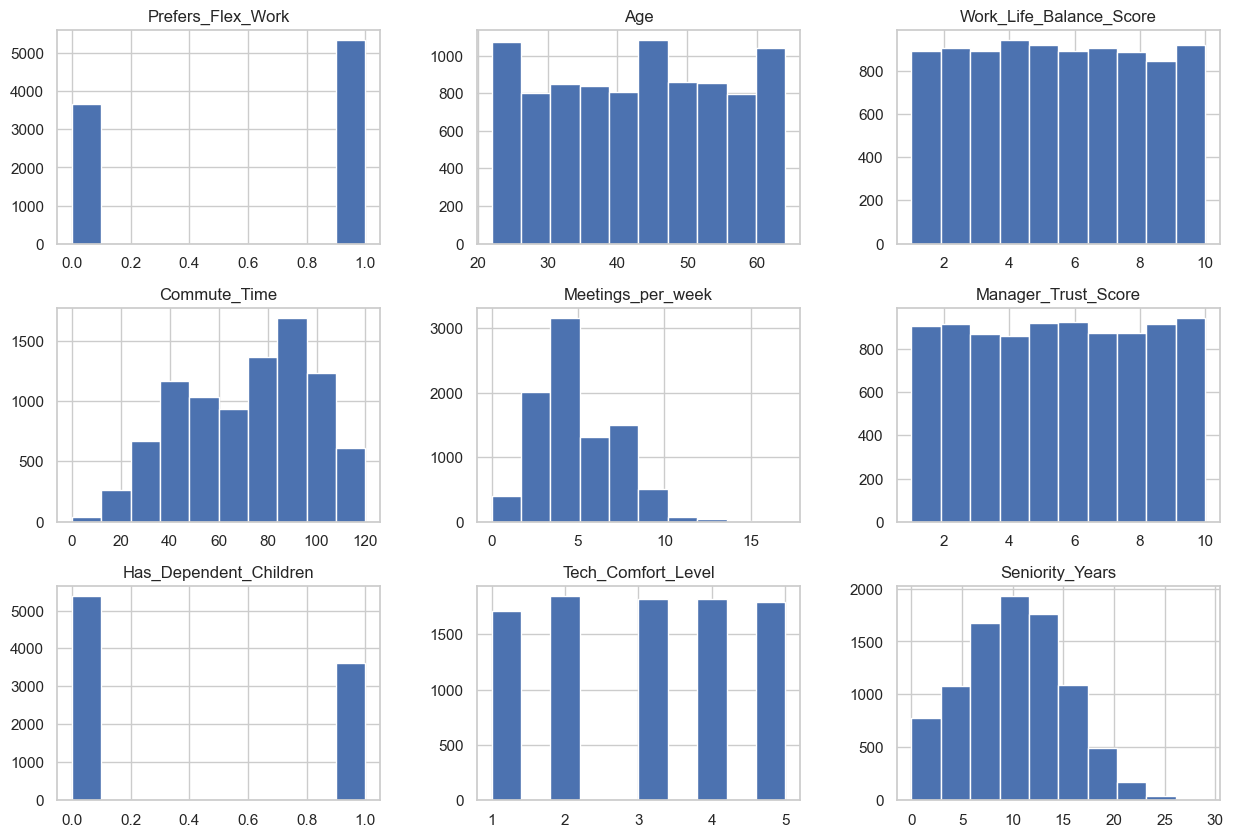

In [13]:
df.drop("ID", axis = 1).hist(figsize=(15,10))
plt.show()

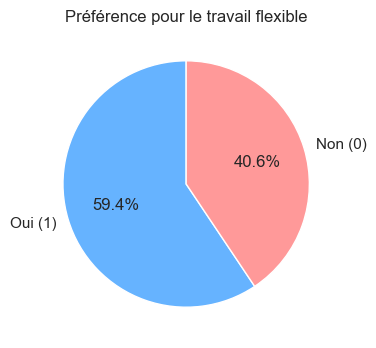

In [14]:
pie_charts = df.Prefers_Flex_Work.value_counts(normalize=True).plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'], labels=['Oui (1)','Non (0)'])
plt.title("Préférence pour le travail flexible")
plt.ylabel("")
plt.show()

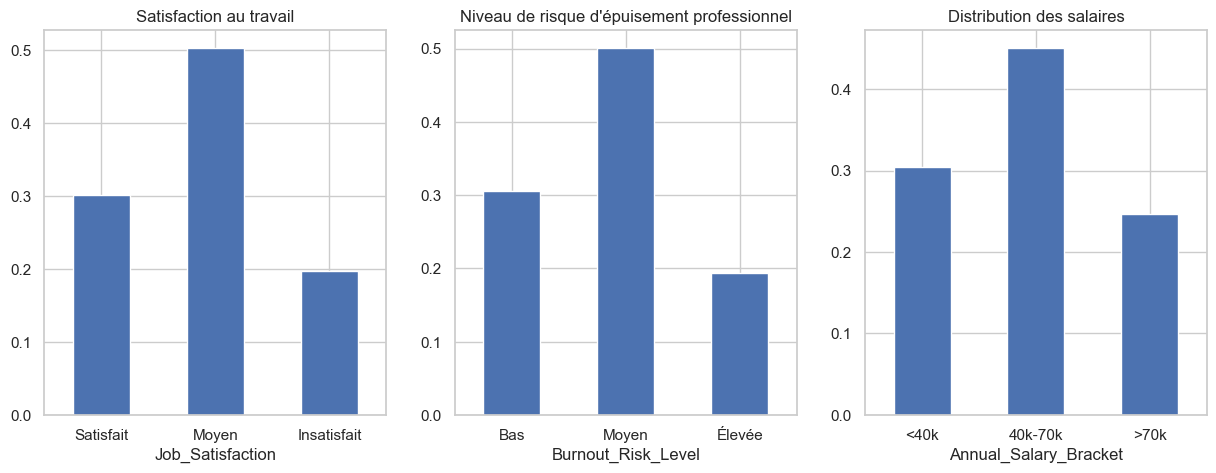

In [15]:
fig, axs = plt.subplots(1, 3, figsize= (15,5))

# Satisfaction au travail
df.Job_Satisfaction.value_counts(normalize=True, sort=False).plot.bar(ax= axs[0])
axs[0].set_title("Satisfaction au travail")
axs[0].set_xticklabels(["Satisfait", "Moyen", "Insatisfait"],rotation=0)
# Niveau de risque d'épuisement professionnel
df.Burnout_Risk_Level.value_counts(normalize=True, sort=False).plot.bar(ax=axs[1])
axs[1].set_title("Niveau de risque d'épuisement professionnel")
axs[1].set_xticklabels(["Bas", "Moyen", "Élevée"],rotation=0)
# Distribution des salaires 
df.Annual_Salary_Bracket.value_counts(normalize=True, sort=False).plot.bar(ax = axs[2])
axs[2].set_title("Distribution des salaires")
axs[2].set_xticklabels(["<40k", "40k-70k", ">70k"],rotation=0)

plt.show()

- Bivarié

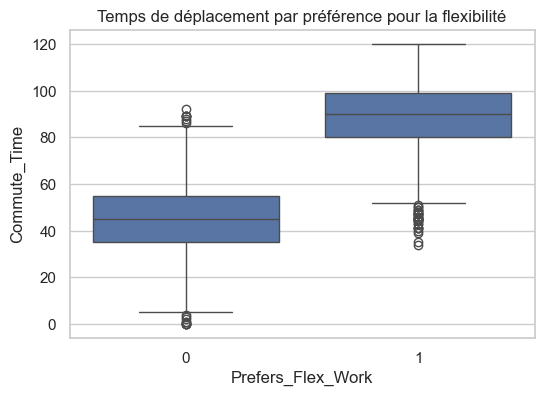

In [16]:
# Temps de déplacement par préférence pour la flexibilité
sns.boxplot(x='Prefers_Flex_Work', y='Commute_Time', data=df)
plt.title("Temps de déplacement par préférence pour la flexibilité")
plt.show()

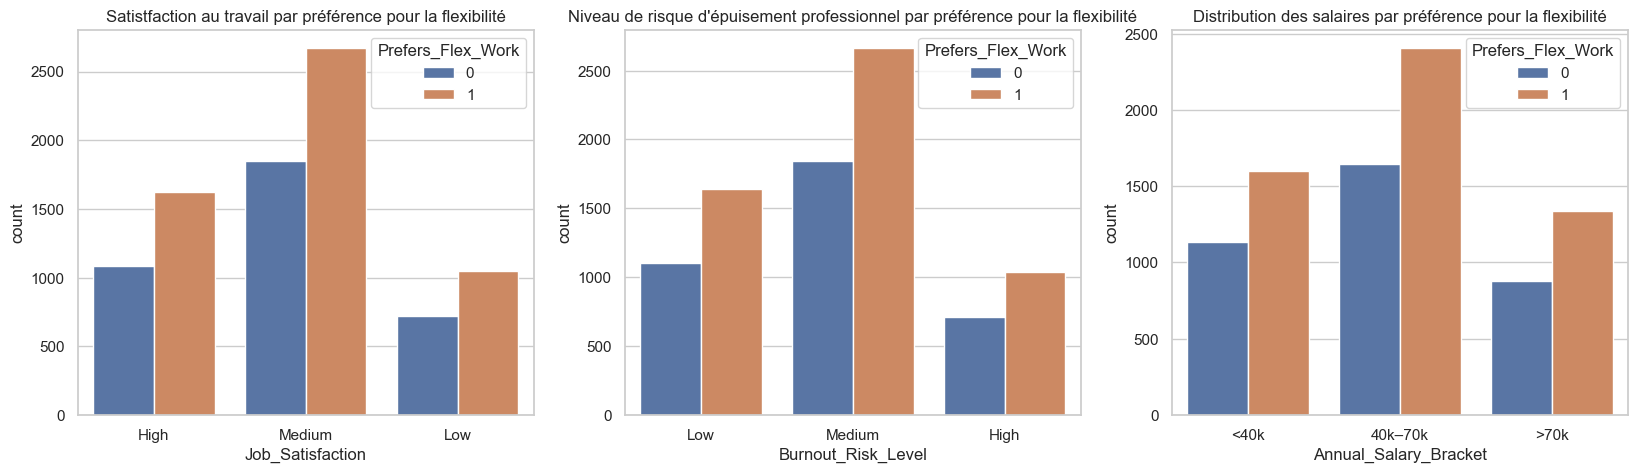

In [17]:
fig, axs = plt.subplots(1,3, figsize= (20,5))

sns.countplot(x='Job_Satisfaction', hue='Prefers_Flex_Work', data=df, ax=axs[0])
axs[0].set_title("Satistfaction au travail par préférence pour la flexibilité")
sns.countplot(x='Burnout_Risk_Level', hue="Prefers_Flex_Work", data=df, ax=axs[1])
axs[1].set_title("Niveau de risque d'épuisement professionnel par préférence pour la flexibilité")
sns.countplot(x='Annual_Salary_Bracket', hue="Prefers_Flex_Work", data=df, ax=axs[2])
axs[2].set_title("Distribution des salaires par préférence pour la flexibilité")

plt.show()


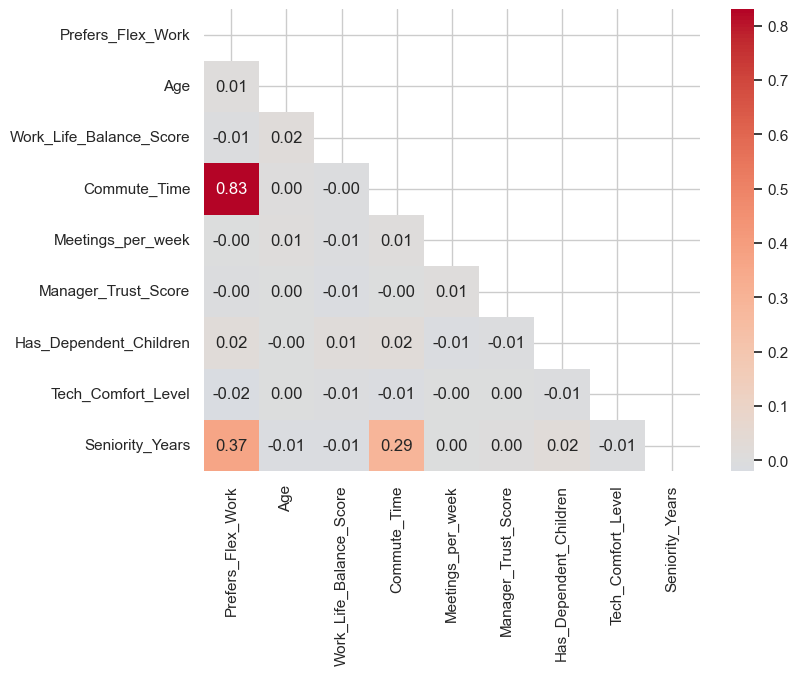

In [18]:
# Mask 
Mask = np.triu(df[Quant_cols].corr())

corr = df[Quant_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", mask=Mask, cmap='coolwarm', center=0)
plt.show()

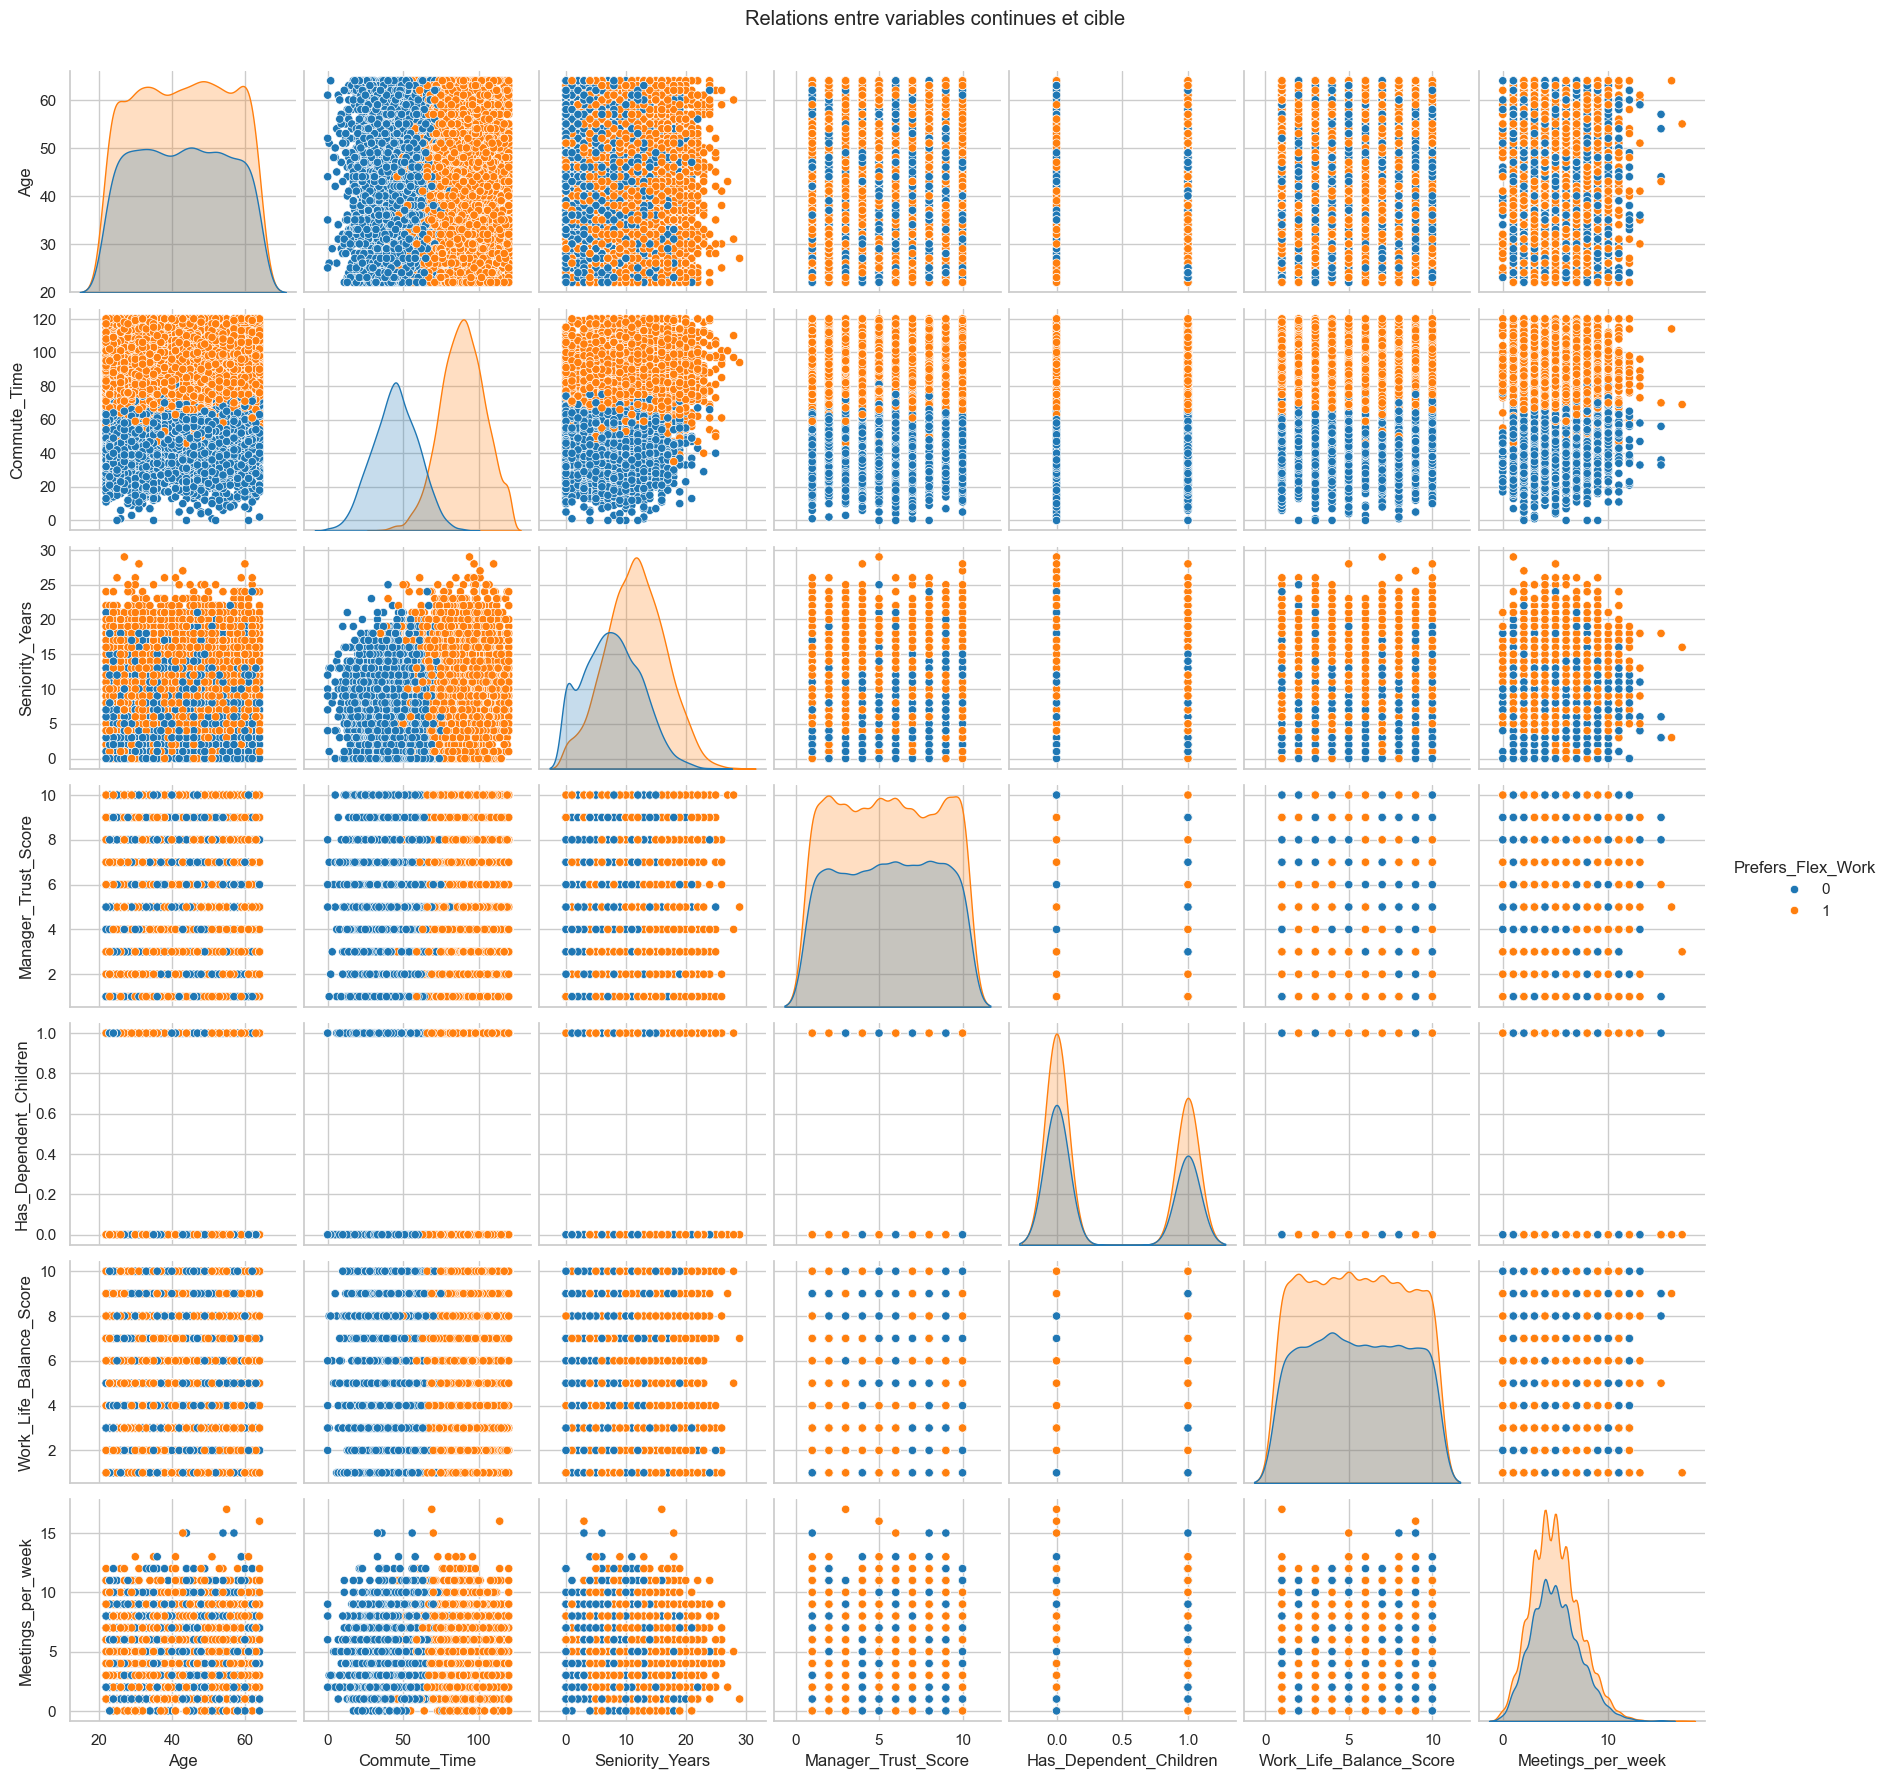

In [19]:
selected_cols = ['Age','Commute_Time','Seniority_Years','Manager_Trust_Score', 'Has_Dependent_Children','Work_Life_Balance_Score','Meetings_per_week','Prefers_Flex_Work']
sns.pairplot(df[selected_cols], hue='Prefers_Flex_Work', palette='tab10')
plt.suptitle('Relations entre variables continues et cible', y=1.02)
plt.show()

#### 1.1.3. Observations et concusions

Le temps de déplacement, la satisfaction au travail, le risque de burnout, la confiance envers le gestionnaire et l'équilibre vie pro/perso influencent fortement la préférence pour un horaire flexible. 

Ces variables clés serviront à mieux prédire et adapter les politiques RH.

#### 1.1.4.Préparation des données

In [20]:
features = df.drop(columns=['ID', 'Prefers_Flex_Work'])
target = df['Prefers_Flex_Work']

- Nettoyage de données

In [21]:
df.isna().sum()

ID                         0
Prefers_Flex_Work          0
Age                        0
Sector                     0
Work_Life_Balance_Score    0
Commute_Time               0
Meetings_per_week          0
Job_Satisfaction           0
Manager_Trust_Score        0
Has_Dependent_Children     0
Tech_Comfort_Level         0
Health_Status              0
Annual_Salary_Bracket      0
Seniority_Years            0
Burnout_Risk_Level         0
dtype: int64

In [22]:
df.duplicated().sum()

np.int64(0)

- Encodage

In [23]:
features_null = df_null.drop(columns=['ID', 'Prefers_Flex_Work'])
target_null = df_null['Prefers_Flex_Work']

In [24]:
features_global = pd.concat([features, features_null], ignore_index=True)
features_global

,Age,Sector,Work_Life_Balance_Score,Commute_Time,Meetings_per_week,Job_Satisfaction,Manager_Trust_Score,Has_Dependent_Children,Tech_Comfort_Level,Health_Status,Annual_Salary_Bracket,Seniority_Years,Burnout_Risk_Level
0,60,Healthcare,10,19,2,High,3,1,2,Average,<40k,12,Low
1,48,Finance,5,102,3,Medium,1,1,2,Average,40k–70k,8,Low
2,29,Retail,2,82,8,Medium,5,1,5,Good,>70k,16,Medium
3,50,Education,5,115,5,Medium,8,1,4,Average,40k–70k,10,High
4,33,Retail,6,34,3,Medium,8,0,4,Average,40k–70k,6,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9015,45,Education,8,46,4,Low,5,1,1,Good,<40k,9,Low
9016,60,Finance,3,108,5,Medium,7,1,4,Average,40k–70k,7,Medium
9017,39,Education,5,55,4,Medium,9,0,4,Poor,40k–70k,12,Low
9018,37,Retail,7,71,9,Medium,4,0,3,Poor,40k–70k,1,High


In [25]:
features_global.replace({'Annual_Salary_Bracket':{
    '<40k': 0,
    '40k–70k': 1,
    '>70k': 2
}}, inplace=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_3624\3976158070.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_global.replace({'Annual_Salary_Bracket':{


In [26]:
ordinal_cols = ['Job_Satisfaction', 'Burnout_Risk_Level', 'Health_Status']

ordinal_maps = [
    ['Low','Medium','High'],
    ['Low','Medium','High'],
    ['Poor','Average','Good']
]

In [27]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_maps)
features_global[ordinal_cols] = ordinal_encoder.fit_transform(features_global[ordinal_cols])

features_global[ordinal_cols].sample(5)

,Job_Satisfaction,Burnout_Risk_Level,Health_Status
3725,0.0,1.0,2.0
8664,1.0,0.0,1.0
3977,2.0,0.0,2.0
230,1.0,0.0,0.0
3180,1.0,1.0,0.0


In [28]:
print(features_global.Has_Dependent_Children.dtype)
print(features_global.Has_Dependent_Children.unique())

int64
[1 0]


In [29]:
print(features_global.Annual_Salary_Bracket)

0       0
1       1
2       2
3       1
4       1
       ..
9015    0
9016    1
9017    1
9018    1
9019    0
Name: Annual_Salary_Bracket, Length: 9020, dtype: int64


In [30]:
print(features_global.Sector.dtype)
print(features_global.Sector.unique())

object
['Healthcare' 'Finance' 'Retail' 'Education' 'Manufacturing' 'IT']


In [31]:
features_global = pd.get_dummies(features_global, columns=['Sector'], drop_first=True, dtype=int)

In [32]:
features_global.shape

(9020, 17)

In [33]:
features_global.sample(5)

,Age,Work_Life_Balance_Score,Commute_Time,Meetings_per_week,Job_Satisfaction,Manager_Trust_Score,Has_Dependent_Children,Tech_Comfort_Level,Health_Status,Annual_Salary_Bracket,Seniority_Years,Burnout_Risk_Level,Sector_Finance,Sector_Healthcare,Sector_IT,Sector_Manufacturing,Sector_Retail
8553,30,5,97,5,1.0,10,1,2,2.0,0,5,0.0,0,0,0,0,1
3545,61,10,49,2,2.0,8,1,2,2.0,2,0,1.0,0,1,0,0,0
8540,62,3,61,5,0.0,7,0,1,1.0,2,26,2.0,1,0,0,0,0
8851,37,7,71,9,1.0,4,0,3,0.0,1,1,2.0,0,0,0,0,1
5949,37,9,80,4,2.0,5,0,3,2.0,1,9,0.0,0,0,1,0,0


- Normalisation

In [34]:
features = features_global.head(len(features)).copy()
features.shape

(9000, 17)

In [35]:
# Normalisation des colonnes numériques
features[Quant_cols.drop("Prefers_Flex_Work")] = scaler.fit_transform(features[Quant_cols.drop("Prefers_Flex_Work")])
features.sample(5)

,Age,Work_Life_Balance_Score,Commute_Time,Meetings_per_week,Job_Satisfaction,Manager_Trust_Score,Has_Dependent_Children,Tech_Comfort_Level,Health_Status,Annual_Salary_Bracket,Seniority_Years,Burnout_Risk_Level,Sector_Finance,Sector_Healthcare,Sector_IT,Sector_Manufacturing,Sector_Retail
882,-0.804014,1.228156,-1.562631,-0.881173,1.0,-0.527062,1.220220,0.701845,1.0,1,-1.150075,2.0,1,0,0,0,0
2681,-0.642722,-1.565313,-0.312839,-0.436585,2.0,0.165226,-0.819524,-0.010849,2.0,1,1.540909,0.0,0,0,0,0,0
2335,0.728261,-0.517762,-1.221779,0.008003,2.0,-0.527062,1.220220,1.414538,0.0,0,-1.150075,2.0,0,1,0,0,0
366,0.486323,1.577340,0.103758,-0.436585,1.0,1.549802,-0.819524,-1.436235,2.0,1,-0.381223,1.0,0,0,0,0,0
3492,-0.158846,-1.216129,0.065886,0.452591,1.0,-0.873206,1.220220,0.701845,1.0,2,-0.573436,1.0,0,0,0,0,0


- Partitionnement des données

In [36]:
# Variables explicatives et la cible
X = features.copy()
y = target

In [37]:
# Diviser les données en ensembles d'entrainement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [38]:
print(f"Taille de l'ensemble d'entrainement: {X_train.shape}; {y_train.shape}")
print(f"Taille de l'ensemble de validation: {X_val.shape}; {y_val.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}; {y_test.shape}")

Taille de l'ensemble d'entrainement: (6300, 17); (6300,)
Taille de l'ensemble de validation: (1350, 17); (1350,)
Taille de l'ensemble de test: (1350, 17); (1350,)


## Modélisation

### 1.2. K-plus proches voisins (KNN)

#### 1.2.1. Modèle, configuration et paramêtres

In [39]:
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [40]:
KNN_model.score(X_val,y_val)

0.9074074074074074

#### 1.2.2. La valeur optimal de k

In [41]:
Val_accuracy = []

k_values = range(1,21)
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    Val_accuracy.append(accuracy)

In [42]:
optimal_k = k_values[np.argmax(Val_accuracy)]
print(f"La valeur optimal de k : {optimal_k}")

La valeur optimal de k : 16


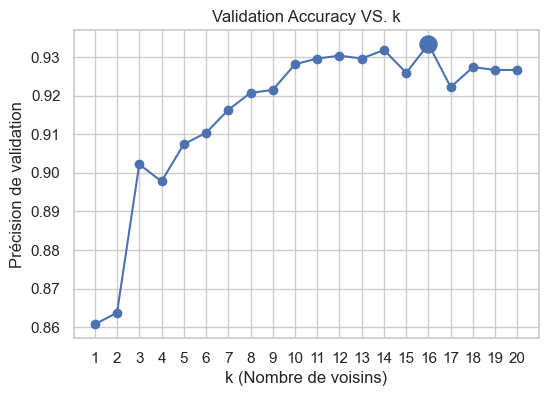

In [43]:
plt.plot(k_values, Val_accuracy, marker ='o')
plt.scatter(x=optimal_k, y=max(Val_accuracy), s=150) # Point optimal
plt.title('Validation Accuracy VS. k')
plt.xlabel("k (Nombre de voisins)")
plt.ylabel("Précision de validation")
plt.xticks(k_values)
plt.show()

In [45]:
KNN_opt = KNeighborsClassifier(n_neighbors=optimal_k)
KNN_opt.fit(X_train, y_train)
print(f"Score de validation pour k optimal : {KNN_opt.score(X_val,y_val)}")

Score de validation pour k optimal : 0.9333333333333333


- Ajustons les paramêtres et la configuration

In [51]:
KNN_distance_euclidean = KNeighborsClassifier(
    n_neighbors=optimal_k,
    weights='distance',
    algorithm='auto',
    metric='euclidean',
)
KNN_distance_euclidean.fit(X_train, y_train)
print(f"Score de validation : {KNN_distance_euclidean.score(X_val, y_val)}")

Score de validation : 0.9281481481481482


In [52]:
KNN_uniform_minkowski = KNeighborsClassifier(
    n_neighbors=optimal_k,
    weights='uniform',
    algorithm='auto',
    metric='minkowski',
)
KNN_uniform_minkowski.fit(X_train, y_train)
print(f"Score de validation : {KNN_uniform_minkowski.score(X_val, y_val)}")

Score de validation : 0.9333333333333333


#### 1.2.3. Évaluation du modèle

In [53]:
Y_test_pred = KNN_opt.predict(X_test)

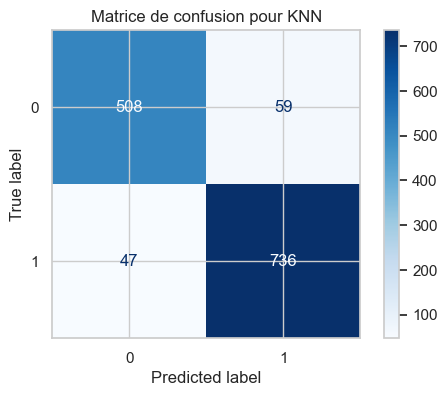

In [55]:
# Matrice de confusion
cm = confusion_matrix(y_test, Y_test_pred)

# Afficher la matrice 
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNN_opt.classes_)
display.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion pour KNN')
plt.show()

In [56]:
# Le taux de succès (accuracy), la sensibilité (recall) et la précision
accuracy = accuracy_score(y_test, Y_test_pred)
recall = recall_score(y_test, Y_test_pred)
precision = precision_score(y_test, Y_test_pred)

print(f"Taux de succès (accuracy) : {accuracy:.2f}")
print(f"Pécision : {precision:.2f}")
print(f"Sensibilité (rappel) : {recall:.2f}")

Taux de succès (accuracy) : 0.92
Pécision : 0.93
Sensibilité (rappel) : 0.94


In [58]:
# Rapport de classification
print(classification_report(y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       567
           1       0.93      0.94      0.93       783

    accuracy                           0.92      1350
   macro avg       0.92      0.92      0.92      1350
weighted avg       0.92      0.92      0.92      1350



#### 1.2.4. Analyse des prédicteurs importants

In [61]:
result = permutation_importance(KNN_opt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_mean': result.importances_mean
}).sort_values(by='Importance_mean', ascending=False)

print(importance_df)

                    Feature  Importance_mean
2              Commute_Time         0.367704
10          Seniority_Years         0.021185
8             Health_Status         0.001852
15     Sector_Manufacturing         0.000000
4          Job_Satisfaction        -0.000444
14                Sector_IT        -0.001037
12           Sector_Finance        -0.001037
16            Sector_Retail        -0.001481
13        Sector_Healthcare        -0.002000
11       Burnout_Risk_Level        -0.002815
9     Annual_Salary_Bracket        -0.004222
6    Has_Dependent_Children        -0.004889
5       Manager_Trust_Score        -0.006000
7        Tech_Comfort_Level        -0.006222
0                       Age        -0.006667
3         Meetings_per_week        -0.006741
1   Work_Life_Balance_Score        -0.012000


L'analyse par **Permutation Importance** a permis d'identifier les variables les plus contributives à la capacité prédictive du modèle KNN. Les
resultats montrent une dominance tres marquée de `Commute_Time` *(importance ~ 0.368)*, loin devant `Seniority_Years` et `Health_Status`.
Ce constat valide ***l'hypothèse selon laquelle la contrainte du temps de déplacement constitue le déterminant principal de la
préférence pour le travail flexible***. Cette information constitue un levier stratégique pour la définition de politiques RH ciblées.

### 1.3. Arbre de décision (CART et C5.0)

#### 1.3.1. Modèle, configuration et paramêtres

- CART (Classification And Regression Trees)

In [65]:
CART = DecisionTreeClassifier(criterion='gini', random_state=42)
CART.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [66]:
CART.score(X_val, y_val)

0.9185185185185185

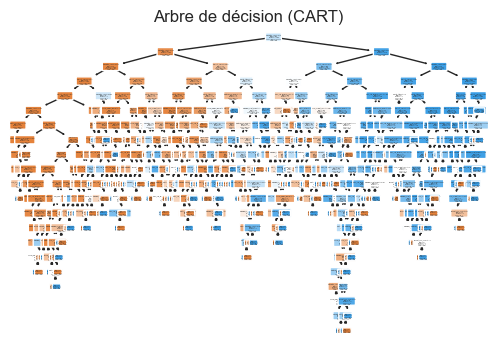

In [67]:
plot_tree(CART, filled=True, feature_names=X_train.columns, class_names=['Non', 'Oui'], rounded=True)
plt.title('Arbre de décision (CART)')
plt.show()

In [68]:
C5_0 = DecisionTreeClassifier(criterion='entropy',random_state=42)
C5_0.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [69]:
C5_0.score(X_val, y_val)

0.9051851851851852

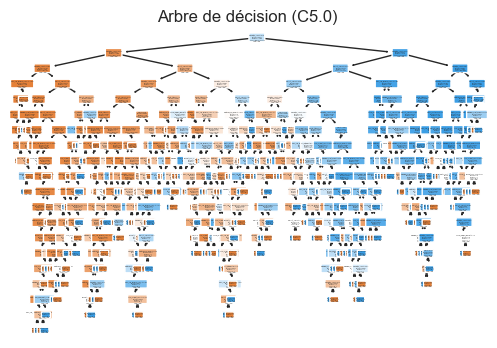

In [70]:
plot_tree(C5_0, filled=True, feature_names=X_train.columns, class_names=['Non', 'Oui'], rounded=True)
plt.title('Arbre de décision (C5.0)')
plt.show()